## CNN - Visualizando as Ativações das Camadas

Objetivo desse notebook é mostrar como podemos utilizar a API Keras para inspecionar as ativações das camadas de um modelo CNN.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras import models

from tensorflow.keras import layers

2022-11-15 19:16:17.799592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Leitura dos Dados

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
def print_number(elem):
    x_img = elem.reshape([28, 28])
    plt.gray()
    plt.imshow(x_img);

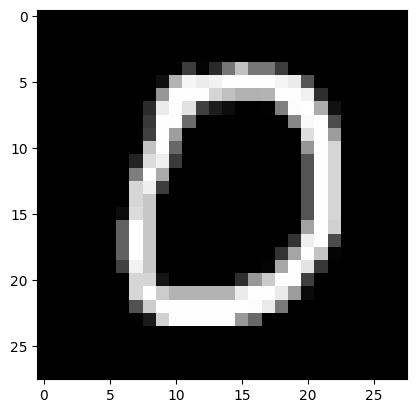

In [4]:
%matplotlib inline
print_number(X_test[10])

## Tratamento dos Dados

In [5]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test  = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [6]:
def normalize(data):
    return data / 255.0

In [7]:
X_train = normalize(X_train)
X_train  = normalize(X_train)

In [8]:
X_train.shape

(60000, 28, 28, 1)

In [9]:
X_test.shape

(10000, 28, 28, 1)

In [10]:
y_train.shape

(60000,)

## Modelo

### Construção

In [11]:
model = keras.Sequential([
    layers.Conv2D(32, (3,3), strides=1, padding="same", activation='relu', input_shape=(28, 28, 1)),
    # aplicar MaxPooling2D aqui gerou overfitting (score de validação em 0.59)
    layers.Conv2D(14, (3,3), strides=2, padding="same", activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2,2)),
    
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(10, activation='softmax')
])

2022-11-15 19:16:23.468777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 14)        4046      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 14)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 14)          0         
                                                                 
 flatten (Flatten)           (None, 686)               0         
                                                                 
 dense (Dense)               (None, 128)               87936     
                                                        

In [13]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Treinamento

In [14]:
epochs = 15

hist = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=64,
    verbose=1,
    shuffle=True
)

Epoch 1/15
750/750 [==============================] - 20s 26ms/step - loss: 1.5812 - accuracy: 0.4474 - val_loss: 0.4595 - val_accuracy: 0.8662
Epoch 2/15
750/750 [==============================] - 22s 29ms/step - loss: 0.4677 - accuracy: 0.8523 - val_loss: 0.3156 - val_accuracy: 0.9049
Epoch 3/15
750/750 [==============================] - 22s 29ms/step - loss: 0.3875 - accuracy: 0.8758 - val_loss: 0.2737 - val_accuracy: 0.9168
Epoch 4/15
750/750 [==============================] - 21s 27ms/step - loss: 0.3466 - accuracy: 0.8882 - val_loss: 0.2393 - val_accuracy: 0.9276
Epoch 5/15
750/750 [==============================] - 21s 28ms/step - loss: 0.3144 - accuracy: 0.8988 - val_loss: 0.2272 - val_accuracy: 0.9290
Epoch 6/15
750/750 [==============================] - 21s 28ms/step - loss: 0.2948 - accuracy: 0.9052 - val_loss: 0.2093 - val_accuracy: 0.9351
Epoch 7/15
750/750 [==============================] - 22s 30ms/step - loss: 0.2747 - accuracy: 0.9129 - val_loss: 0.2021 - val_accuracy:

### Visualizando Resultado Treinamento

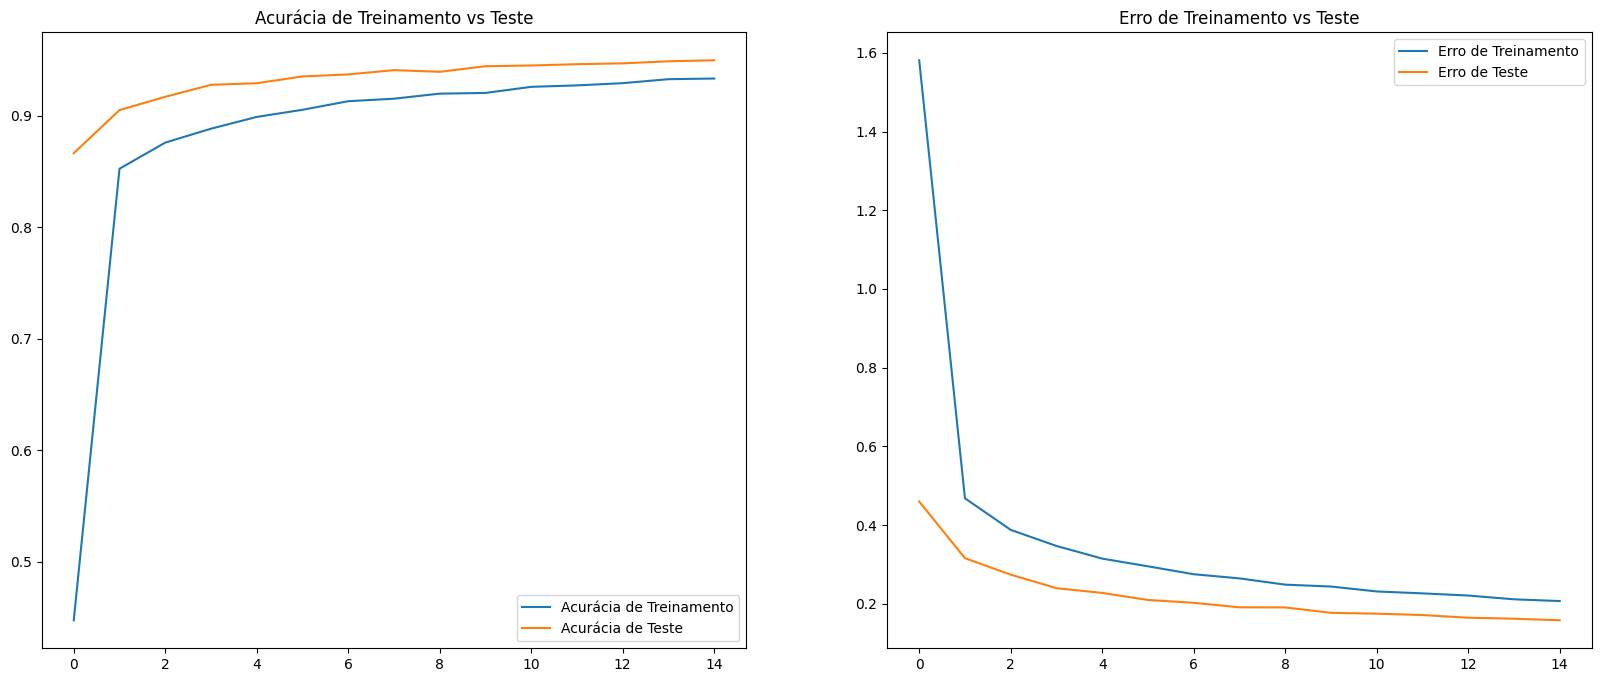

In [15]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Teste')
plt.legend(loc='lower right')
plt.title('Acurácia de Treinamento vs Teste')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro de Treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Teste')
plt.legend(loc='upper right')
plt.title('Erro de Treinamento vs Teste')
plt.show()

## Validando o Modelo

In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9444000124931335


## Inspecionando as Camadas do Modelo

Separamos um elemento dos dados de teste:

In [17]:
img_test = X_test[110]
img_test.shape

(28, 28, 1)

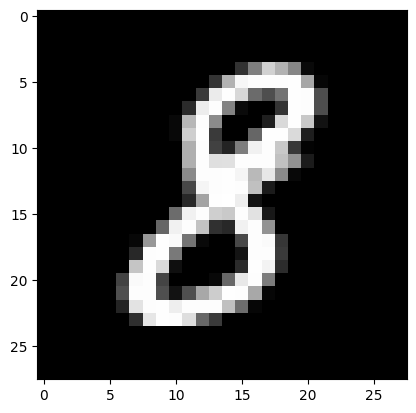

In [18]:
%matplotlib inline
print_number(img_test)

In [19]:
input_test = normalize(np.array([img_test]))
input_test.shape

(1, 28, 28, 1)

### Criando Modelo Customizado com as Camadas que Serão Visualizadas

In [20]:
model.layers

Definimos o index até qual iremos extrair as camadas (exclusivo):

In [21]:
last_layer_inspect = 3

Criamos um modelo manualmente apenas com as camadas que iremos visualizar.

In [22]:
# pegamos apenas as camadas convolução
layer_outputs = [layer.output for layer in model.layers[:last_layer_inspect]]

activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

In [23]:
activation_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 14)        4046      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 14)         0         
 )                                                               
                                                                 
Total params: 4,366
Trainable params: 4,366
Non-trainable params: 0
_________________________________________________________________


### Obtendo as Ativações das Camadas de um Exemplo

Invoca o modelo para retornar o array com a saída das ativações de cada camada:

In [24]:
activations = activation_model.predict(input_test)

1/1 [==============================] - 0s 133ms/step


In [25]:
first_layer_activation = activations[0]
second_layer_activation = activations[1]

Exibimos o formato da ativação de saída da camada, note que temos 32 filtros na primeira camada e 14 na segunda:

In [27]:
first_layer_activation.shape

(1, 28, 28, 32)

In [28]:
second_layer_activation.shape

(1, 14, 14, 14)

### Visualizando um Filtro da Camada

Podemos visualizar a saída de um filtro da primeira e segunda camada:

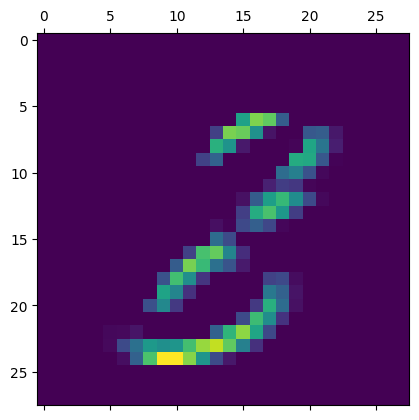

In [29]:
plt.matshow(first_layer_activation[0, :, :, 2], cmap ='viridis');

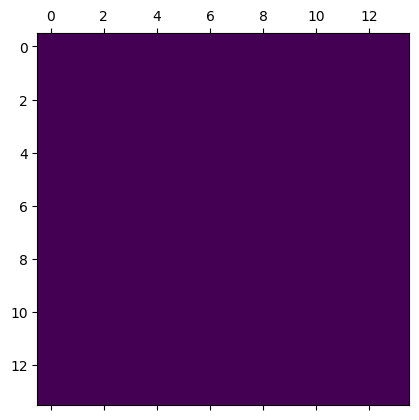

In [30]:
plt.matshow(second_layer_activation[0, :, :, 2], cmap ='viridis');

### Visualizando a Ativação da Primeira Camada

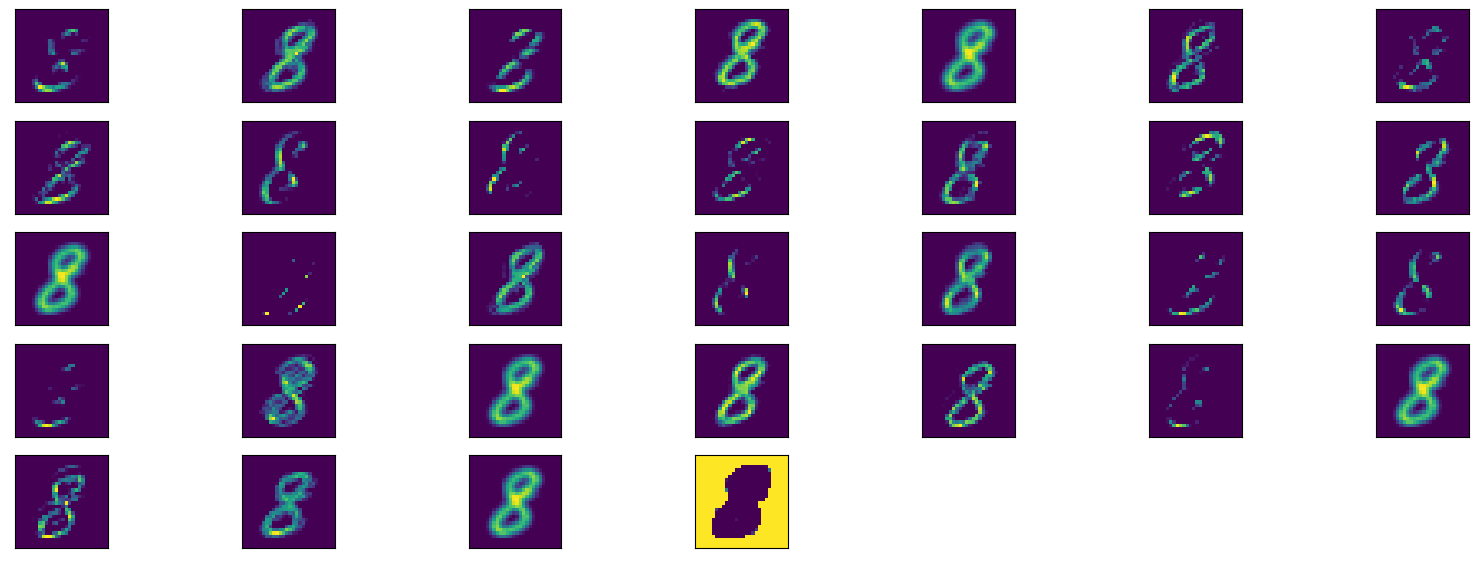

In [31]:
plt.figure(figsize=(20, 7));

total_filters = first_layer_activation.shape[3]

for i in range(total_filters):
    filter_output = first_layer_activation[0, :, :, i]
    # só exibimos os filtros que teve ativação
    # if np.sum(layer_output) > 0:
    ax = plt.subplot(math.ceil(total_filters / 7), 7, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(filter_output, cmap='viridis')

### Visualizando a Ativação da Segunda Camada

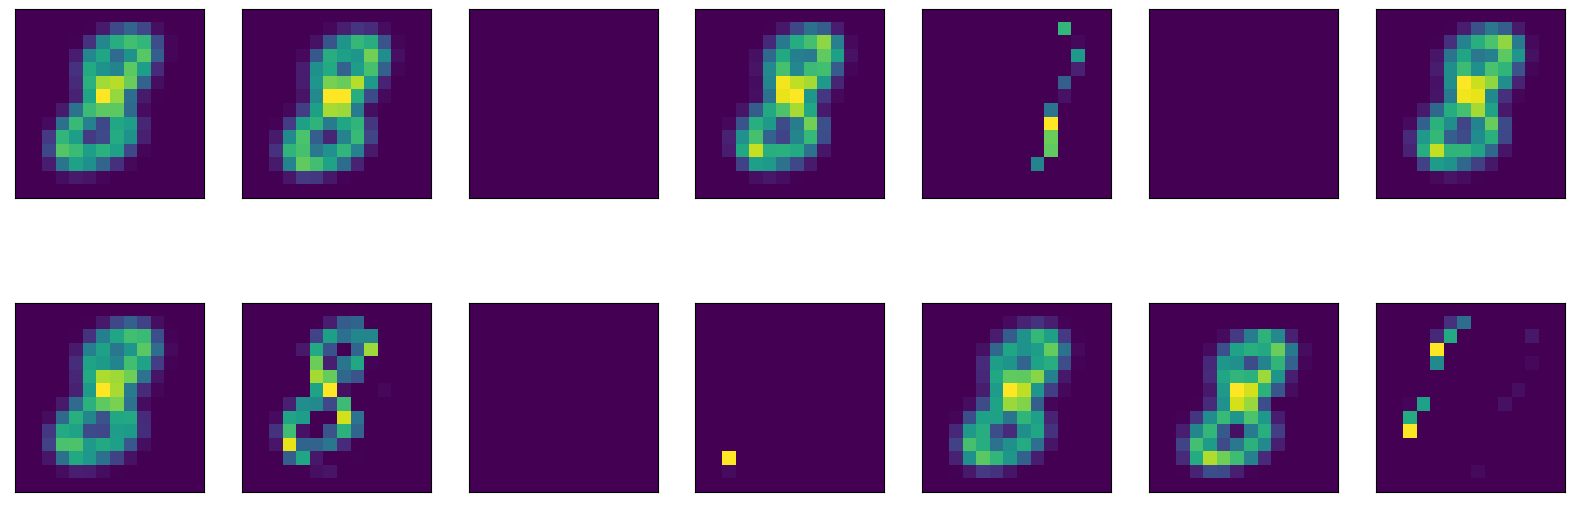

In [32]:
plt.figure(figsize=(20, 7));

total_filters = second_layer_activation.shape[3]

for i in range(total_filters):
    filter_output = second_layer_activation[0, :, :, i]
    ax = plt.subplot(math.ceil(total_filters / 7), 7, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(filter_output, cmap='viridis')

## Visualizando a Ativação de Todas as Camadas

In [33]:
layer_names = []
  
for layer in model.layers[:last_layer_inspect]:
  layer_names.append(layer.name)

layer_names

['conv2d', 'conv2d_1', 'max_pooling2d']

In [34]:
def show_layers_activations(activations):
    for j in range(last_layer_inspect):
        print('\n=== Camada', layer_names[j], '===')
        layer_num_filters = activations[j].shape[3]

        plt.figure(figsize=(20, 7));
        
        for i in range(layer_num_filters):
            filter_output = activations[j][0, :, :, i]
            
            ax = plt.subplot(math.ceil(layer_num_filters / 7 + 1), 7, i+1)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.imshow(filter_output, cmap='viridis')
        plt.show()

1/1 [==============================] - 0s 24ms/step

=== Camada conv2d ===


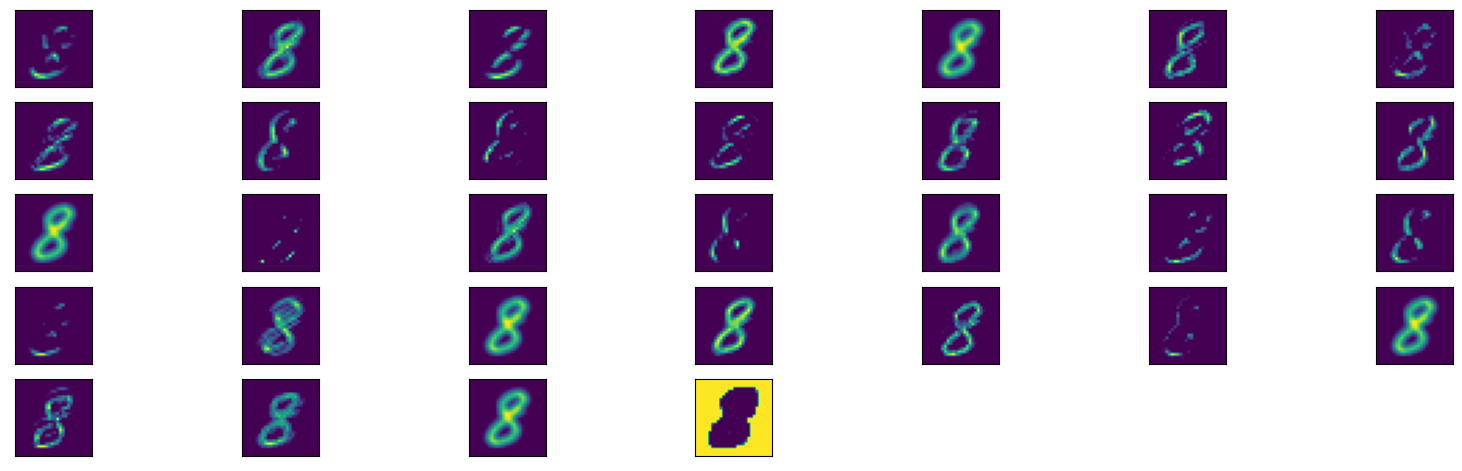


=== Camada conv2d_1 ===


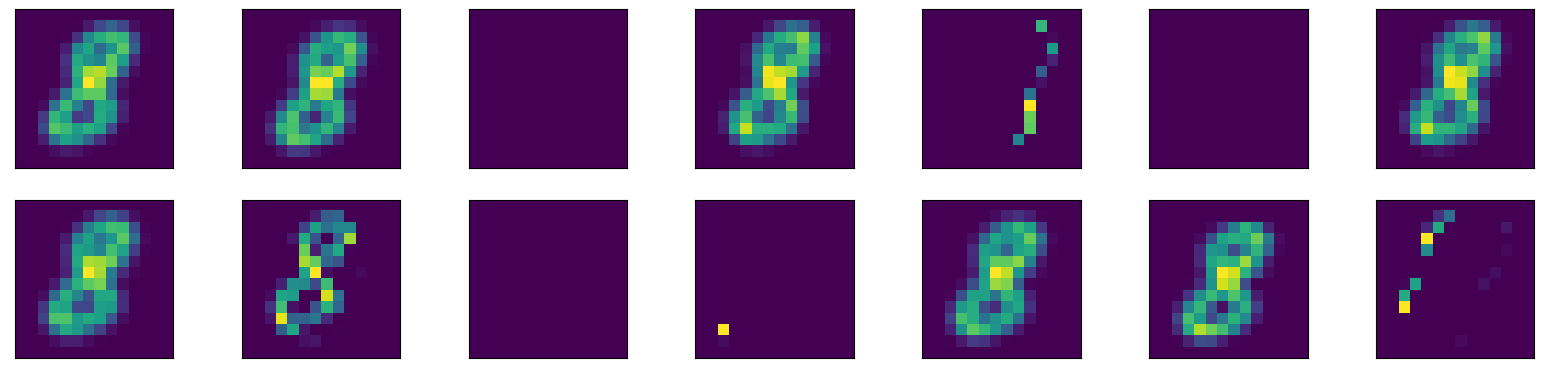


=== Camada max_pooling2d ===


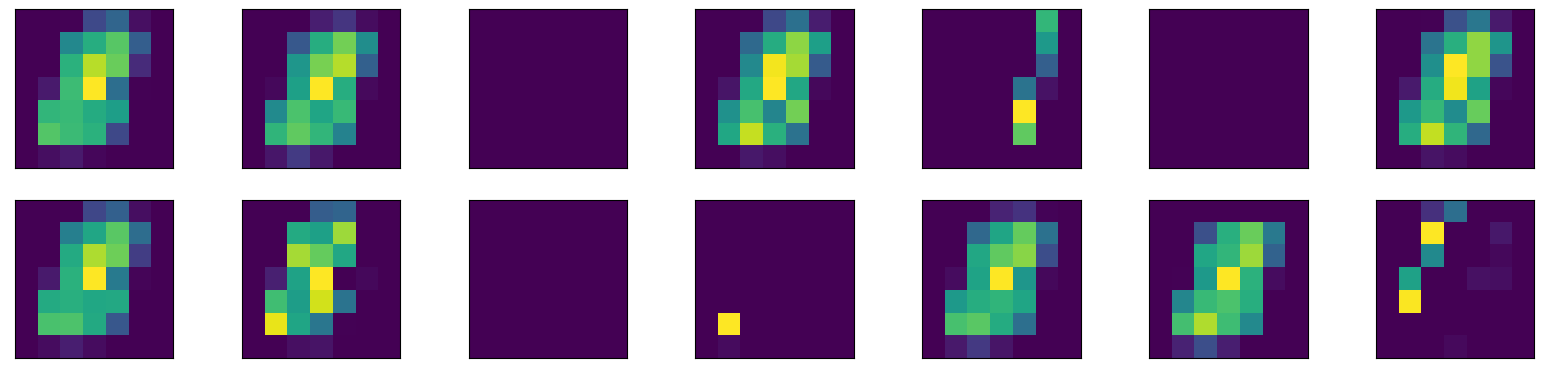

In [35]:
input_viz = normalize(np.array([X_test[110]]))
activations = activation_model.predict(input_viz)
show_layers_activations(activations)

1/1 [==============================] - 0s 31ms/step

=== Camada conv2d ===


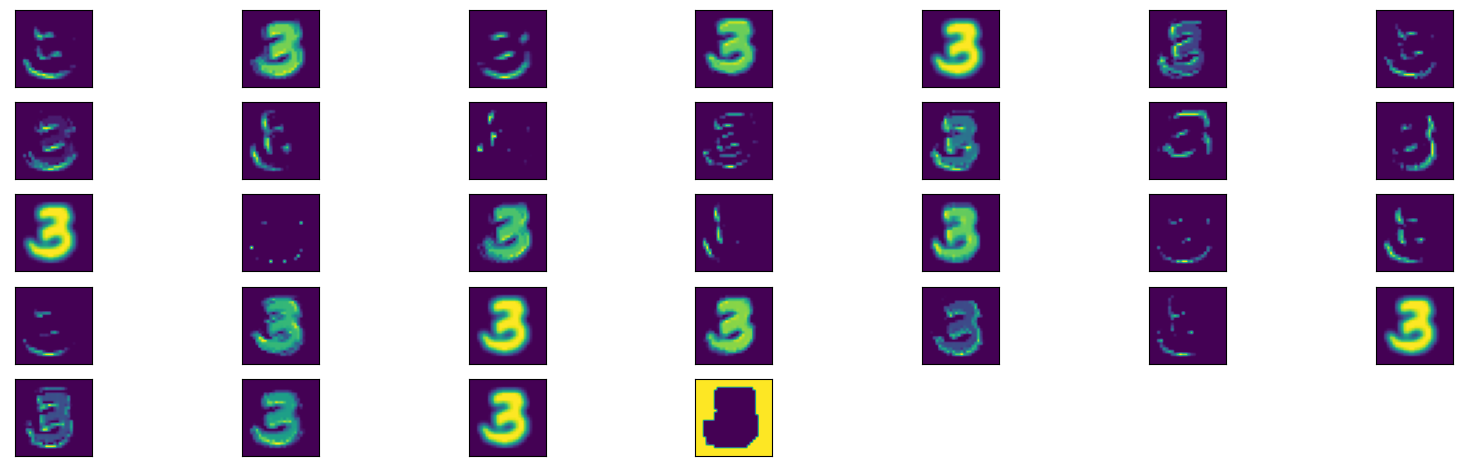


=== Camada conv2d_1 ===


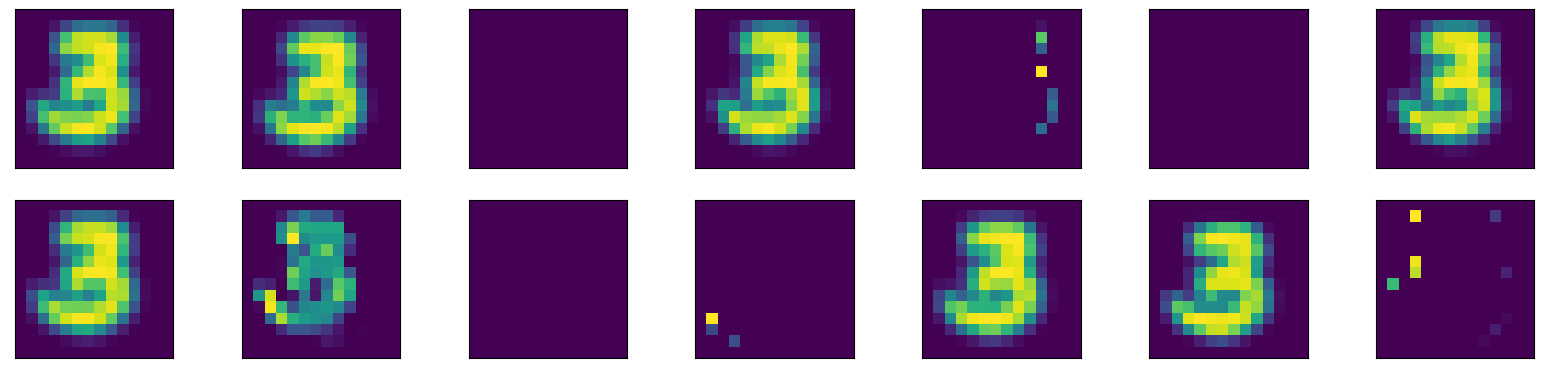


=== Camada max_pooling2d ===


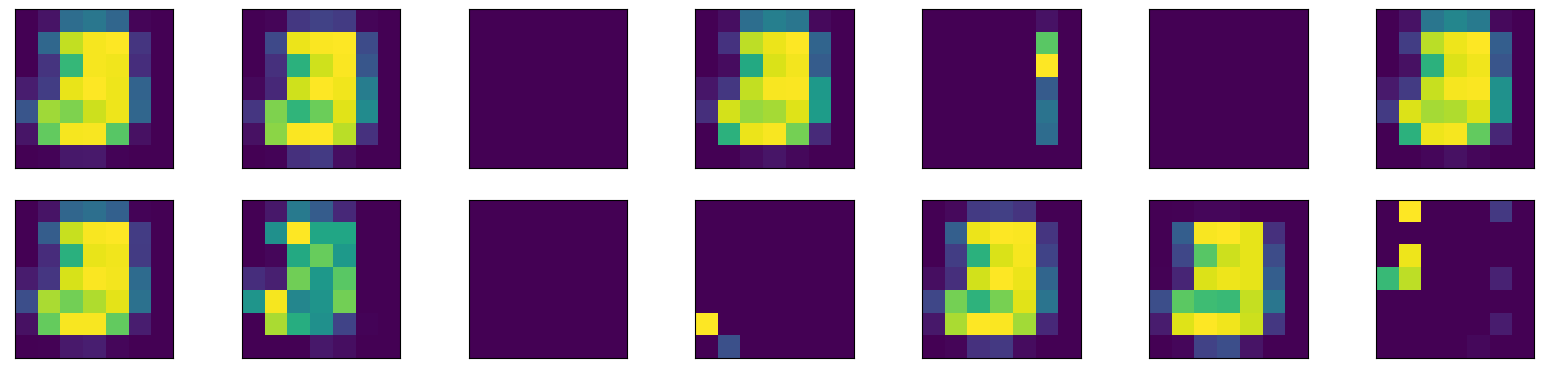

In [36]:
input_viz = normalize(np.array([X_test[200]]))
activations = activation_model.predict(input_viz)
show_layers_activations(activations)

1/1 [==============================] - 0s 21ms/step

=== Camada conv2d ===


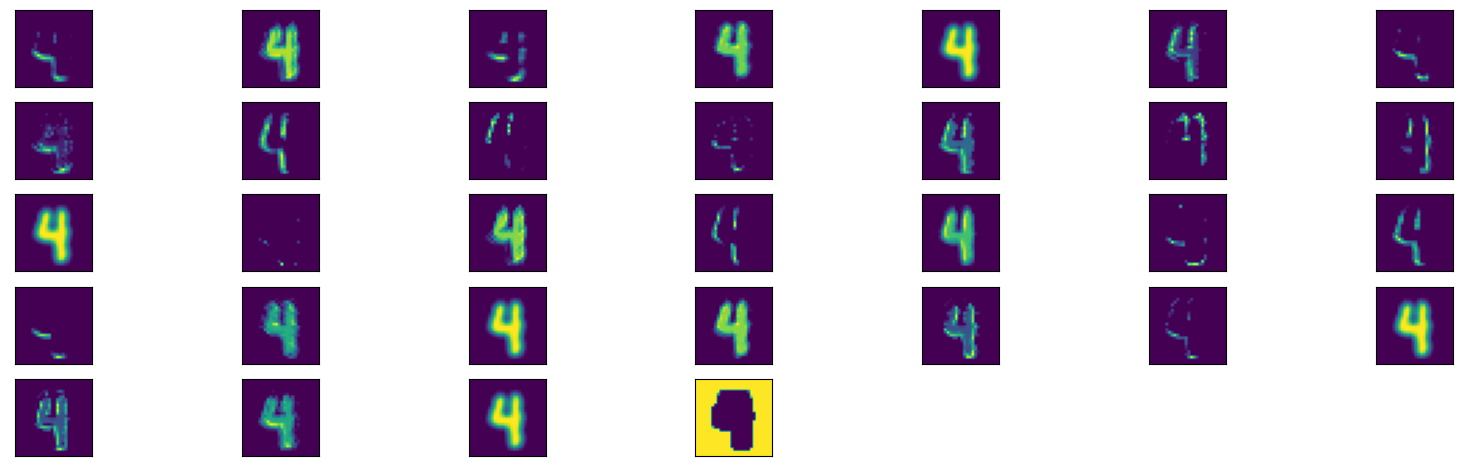


=== Camada conv2d_1 ===


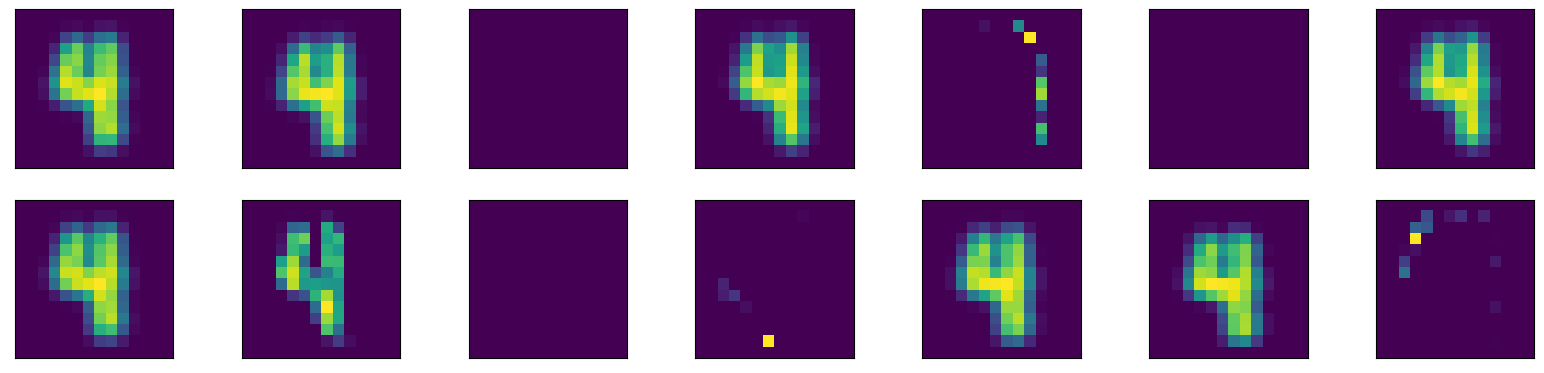


=== Camada max_pooling2d ===


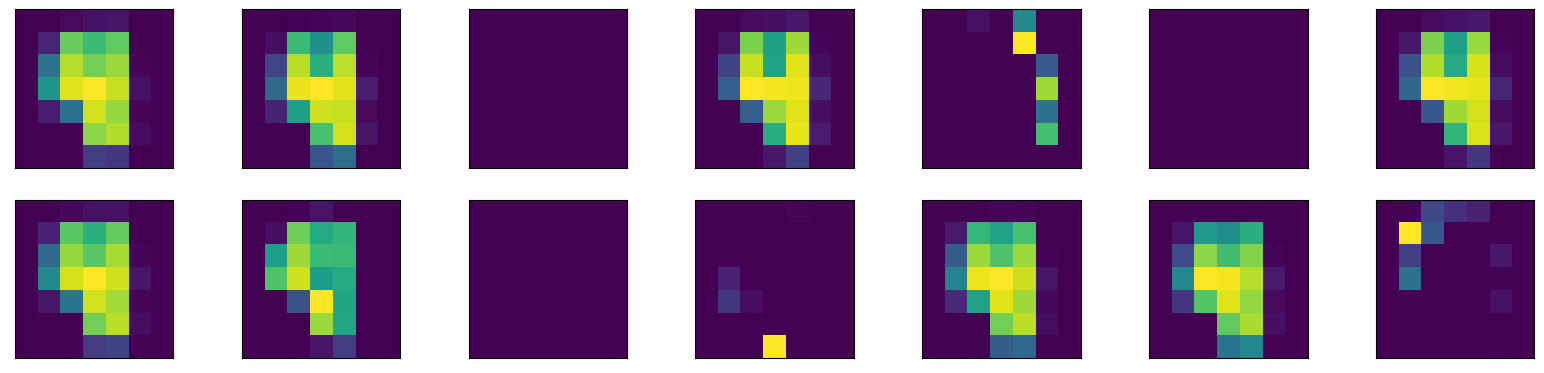

In [37]:
input_viz = normalize(np.array([X_test[250]]))
activations = activation_model.predict(input_viz)
show_layers_activations(activations)